<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/vanillawithtrasformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [54]:
%cd /gdrive/My Drive/ANN/homework2

/gdrive/My Drive/ANN/homework2


In [109]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [110]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [127]:
dataset = pd.read_csv('Training.csv',dtype=np.float32)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.9770,4.3349,10.6728,1.7669,3.2244,51.6815,3.6543
1,8.0782,4.4462,10.5616,1.7072,3.3257,51.5636,3.4767
2,8.0284,4.2237,10.5616,1.6491,3.1746,50.8631,3.4767
3,8.0284,4.2237,10.5616,1.7072,3.1746,45.8416,3.4767
4,7.8757,4.4462,10.4504,1.7072,3.2759,47.1264,3.4767


In [128]:
#CHECK FOR NaN VALUES

In [129]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()

Sponginess            0
Wonder level          0
Crunchiness           0
Loudness on impact    0
Meme creativity       0
Soap slipperiness     0
Hype root             0
dtype: int64

No Nan Values

In [130]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


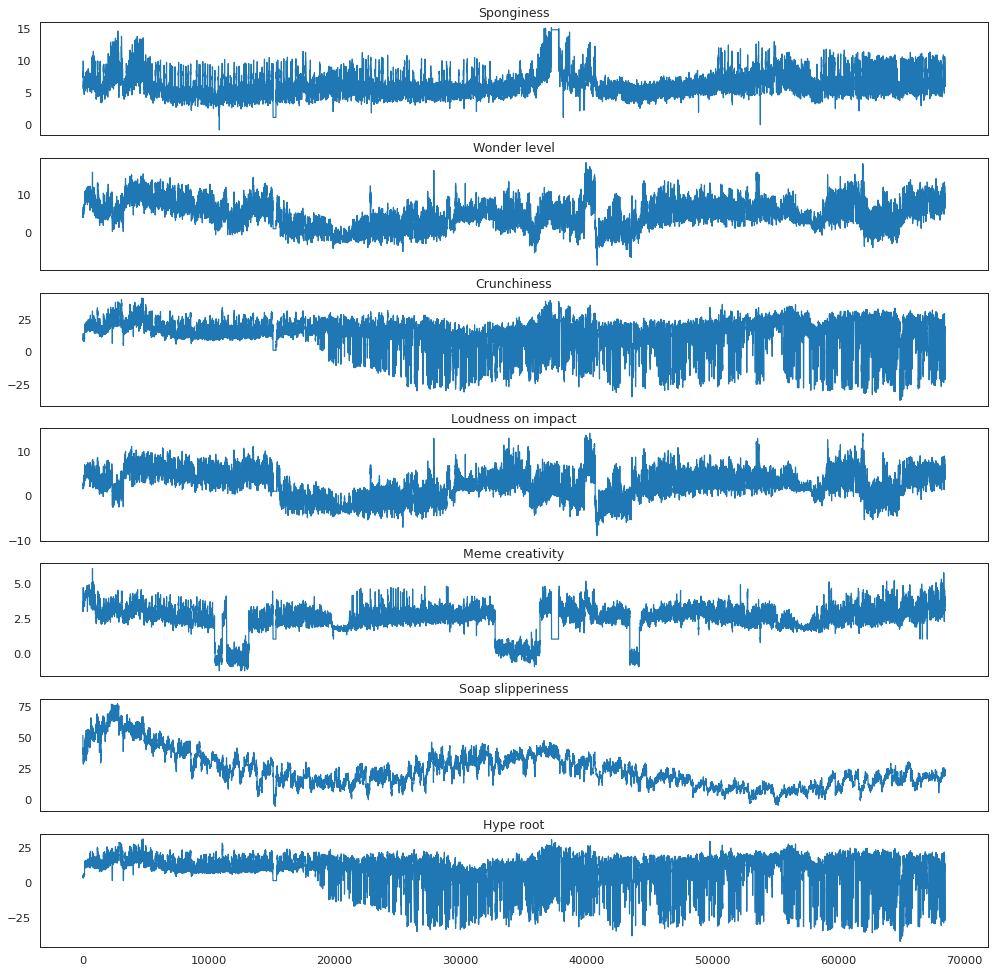

In [131]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Check for important statistic behavoir

Kurtosis of normal distribution: 2.9391110127872633
Skewness of normal distribution: 1.2706395387649536


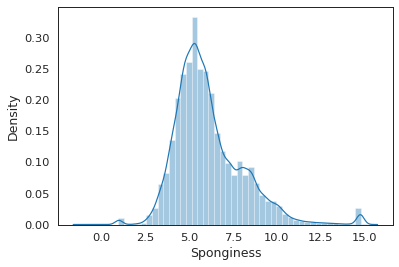

In [132]:
sns.distplot(dataset.Sponginess);
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.Sponginess)))
print('Skewness of normal distribution: {}'.format(stats.skew(dataset.Sponginess)))

NORMAL PROBABILITY PLOT

,count,mean,std,min,25%,50%,75%,max
Sponginess,68528.0000,6.0940,1.9417,-0.9721,4.7914,5.7028,7.0673,15.1067
Wonder level,68528.0000,4.6956,3.3742,-8.4504,2.2234,4.6686,7.1154,18.1229
Crunchiness,68528.0000,13.3374,11.7030,-37.5817,10.6728,15.6761,20.5681,41.1388
Loudness on impact,68528.0000,2.4487,3.0017,-9.0281,0.4688,2.5338,4.6570,14.0360
Meme creativity,68528.0000,2.4072,0.9940,-1.2759,2.1122,2.6185,3.0219,6.0564
Soap slipperiness,68528.0000,23.2379,14.2980,-6.0069,12.5602,20.1514,31.2452,77.3716
Hype root,68528.0000,8.2314,11.2851,-42.7692,6.6042,10.9683,15.3341,31.0244


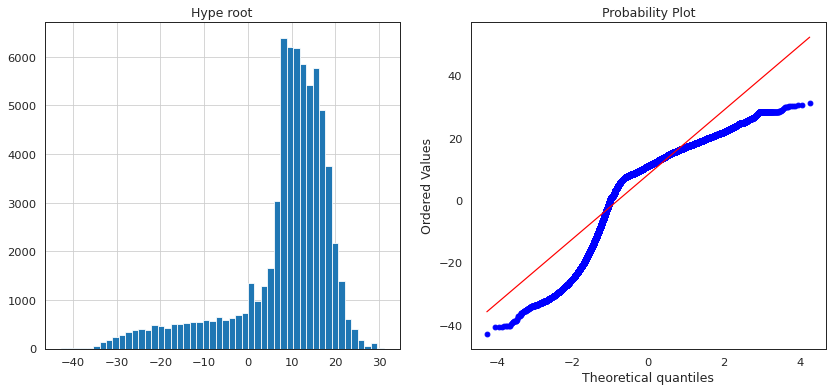

In [133]:
#HYPE ROOT
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['Hype root'].hist(bins=50)
plt.title('Hype root')
plt.subplot(1,2,2)
stats.probplot(dataset['Hype root'], plot=plt);
dataset.describe().T

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

In [134]:
#Wonder level
ad_fuller_result_2=adfuller(dataset['Wonder level'])
print ('realWonderlevel')
print( 'ADF Statistic: ', { ad_fuller_result_2[0]})
print( 'p value: ', { ad_fuller_result_2[1]})

realWonderlevel
ADF Statistic:  {-11.817171517549166}
p value:  {8.583264463560346e-22}


IT IS STATIONARY IF THE P VALUE IS LESS THAN 0.05

In [135]:
#Hype Root
ad_fuller_result_2=adfuller(dataset['Hype root'])
print ('realHypeRoot')
print( 'ADF Statistic: ', { ad_fuller_result_2[0]})
print( 'p value: ', { ad_fuller_result_2[1]})

realHypeRoot
ADF Statistic:  {-26.959039937074127}
p value:  {0.0}


AS WE CAN SEE THIS IS NOT LESS THAN 0.05, SO WE CAN APPLY SOME TRASFORMATIONS

LOG TRASFORMATION

TRASFORMATION

The goal with transformations is to “transform” or remove any trend, change in variance, or seasonality – make our time series data stationary. Mathematical transformations apply some function for each value of the time series to remove a pattern. The most common mathematical transformations are:

Log Transformations Power Transformations More Sophisticated Transforms Log Transformations Converting time series data to a logarithmic scale reduces the variability of the data. Data scientists frequently use log transformations when dealing with price data. Log prices normalize the rate of change. In other words, a 10-20 move looks the same as a 100-200 move.

In [136]:
dataset = dataset.apply(np.log)

In [137]:
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,2.0766,1.4667,2.3677,0.5692,1.1707,3.9451,1.2959
1,2.0892,1.4920,2.3572,0.5348,1.2017,3.9428,1.2461
2,2.0830,1.4407,2.3572,0.5002,1.1552,3.9291,1.2461
3,2.0830,1.4407,2.3572,0.5348,1.1552,3.8252,1.2461
4,2.0638,1.4920,2.3466,0.5348,1.1866,3.8528,1.2461


In [138]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68526 non-null  float32
 1   Wonder level        62571 non-null  float32
 2   Crunchiness         59908 non-null  float32
 3   Loudness on impact  53931 non-null  float32
 4   Meme creativity     65035 non-null  float32
 5   Soap slipperiness   67943 non-null  float32
 6   Hype root           57710 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


In [141]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()

Sponginess                2
Wonder level           5957
Crunchiness            8620
Loudness on impact    14597
Meme creativity        3493
Soap slipperiness       585
Hype root             10818
dtype: int64

In [144]:
dataset=dataset[~np.isnan(dataset)]

NORMALIZATION OF DATA AND SPLIT INTO TRAIN AND TEST

```
# Questo è formattato come codice
```



(62768, 7) (5760, 7)


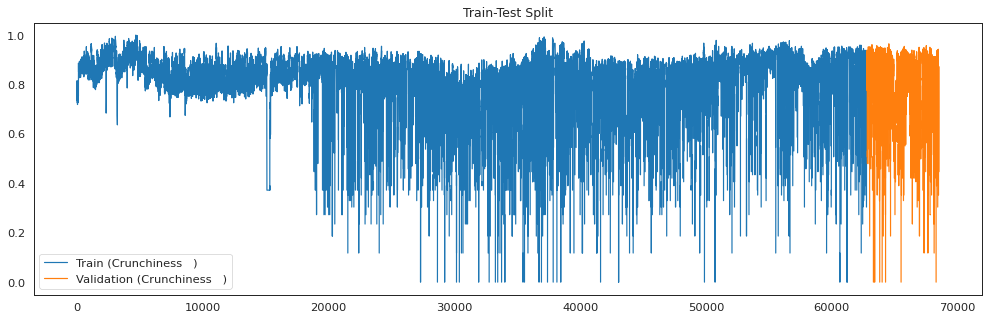

In [146]:
test_size = 5760
X_train_raw = dataset.iloc[:-test_size]
#_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
#y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness   )')
plt.plot(X_test_raw.Crunchiness , label='Validation (Crunchiness   )')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [147]:
X_train_raw


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.7648,0.7196,0.7722,0.6255,0.8751,0.9430,0.6619
1,0.7695,0.7246,0.7704,0.6193,0.8813,0.9426,0.6541
2,0.7672,0.7145,0.7704,0.6130,0.8721,0.9407,0.6541
3,0.7672,0.7145,0.7704,0.6193,0.8721,0.9260,0.6541
4,0.7601,0.7246,0.7686,0.6193,0.8783,0.9299,0.6541
...,...,...,...,...,...,...,...
62763,0.5810,nan,0.7807,nan,0.7866,0.7615,0.7728
62764,0.6034,nan,0.7889,nan,0.7914,0.7580,0.7766
62765,0.6034,nan,0.7967,nan,0.7767,0.7495,0.7862
62766,0.6070,nan,0.7982,nan,0.7767,0.7495,0.7908


In [160]:
X_train_raw=X_train_raw[~np.isnan(X_train_raw)]

In [161]:
X_train_raw

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.7648,0.7196,0.7722,0.6255,0.8751,0.9430,0.6619
1,0.7695,0.7246,0.7704,0.6193,0.8813,0.9426,0.6541
2,0.7672,0.7145,0.7704,0.6130,0.8721,0.9407,0.6541
3,0.7672,0.7145,0.7704,0.6193,0.8721,0.9260,0.6541
4,0.7601,0.7246,0.7686,0.6193,0.8783,0.9299,0.6541
...,...,...,...,...,...,...,...
62763,0.5810,nan,0.7807,nan,0.7866,0.7615,0.7728
62764,0.6034,nan,0.7889,nan,0.7914,0.7580,0.7766
62765,0.6034,nan,0.7967,nan,0.7767,0.7495,0.7862
62766,0.6070,nan,0.7982,nan,0.7767,0.7495,0.7908


In [166]:
X_train_raw=X_train_raw[~X_train_raw.isin([np.nan, np.inf, -np.inf]).any(1)]


In [167]:
X_train_raw


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.7648,0.7196,0.7722,0.6255,0.8751,0.9430,0.6619
1,0.7695,0.7246,0.7704,0.6193,0.8813,0.9426,0.6541
2,0.7672,0.7145,0.7704,0.6130,0.8721,0.9407,0.6541
3,0.7672,0.7145,0.7704,0.6193,0.8721,0.9260,0.6541
4,0.7601,0.7246,0.7686,0.6193,0.8783,0.9299,0.6541
...,...,...,...,...,...,...,...
62715,0.8499,0.6870,0.8986,0.5609,0.8623,0.7187,0.8672
62716,0.8250,0.7093,0.9003,0.5773,0.8930,0.7187,0.8753
62717,0.8328,0.7433,0.8677,0.6730,0.8813,0.7057,0.8242
62718,0.8518,0.7342,0.8322,0.5428,0.8930,0.6855,0.7482


In [168]:
#Hype Root
ad_fuller_result_2=adfuller(X_train_raw['Hype root'])
print ('realHypeRoot')
print( 'ADF Statistic: ', { ad_fuller_result_2[0]})
print( 'p value: ', { ad_fuller_result_2[1]})

realHypeRoot
ADF Statistic:  {-16.017304960337643}
p value:  {6.260089421863655e-29}


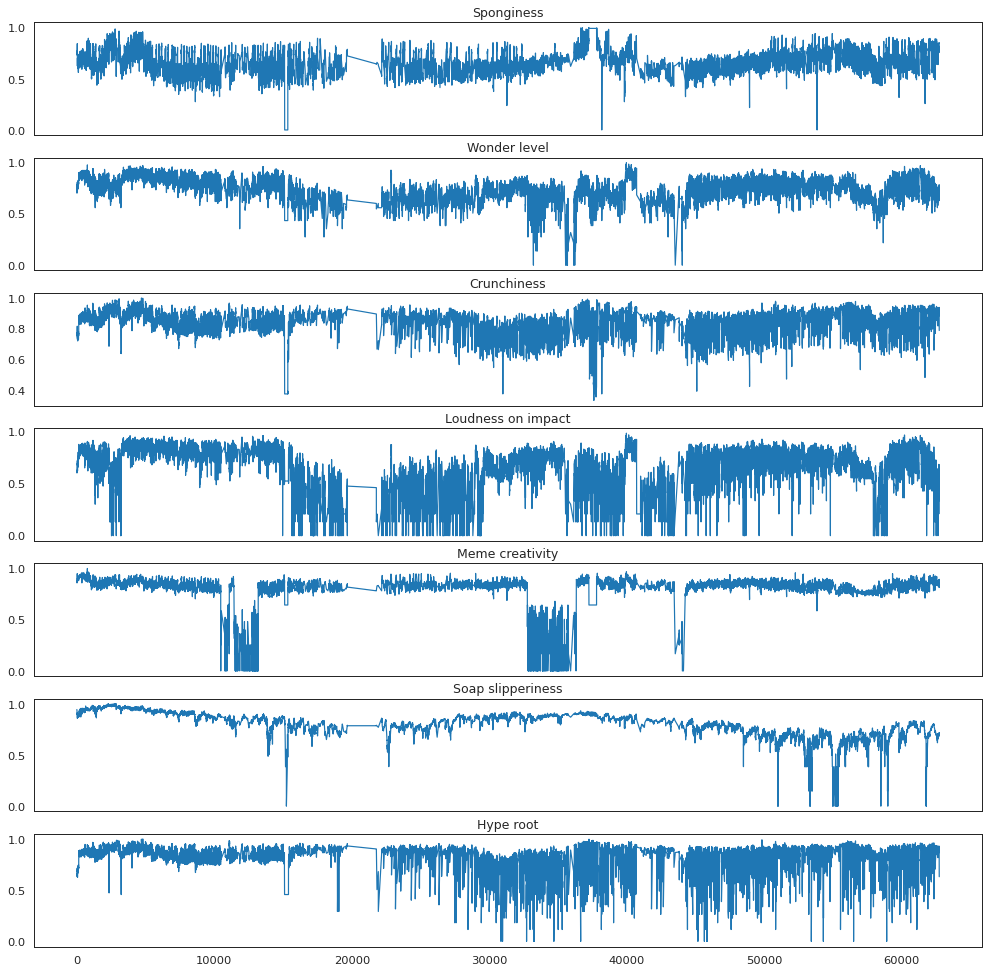

In [169]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(X_train_raw, dataset.columns)

top cazzo

In [170]:
window = 200
stride= 10

In [171]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 200, 7)

In [172]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=5, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [173]:
#Multivariate Forecating (Direct)
target_labels = dataset.columns
telescope = 864

In [174]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3654, 200, 7), (3654, 864, 7), (474, 200, 7), (474, 864, 7))

In [175]:

def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [178]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs =200

In [179]:
from pandas.core.dtypes.cast import convert_dtypes
#merge convolution and recurrent networks
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    

    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dropout)
    #attention_layer = attention()(dense)

    #try without dense
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    #this could be the last layer
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 200, 128)          69632     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 6048)              780192    
                                                                 
 reshape_2 (Reshape)         (None, 864, 7)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 864, 7)            56    

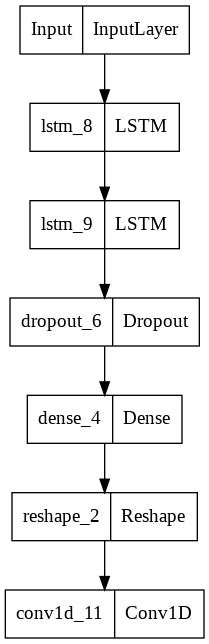

In [180]:

model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [183]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
46/46 [==============================] - 38s 819ms/step - loss: 0.1459 - mae: 0.2957 - val_loss: 0.0679 - val_mae: 0.2152 - lr: 0.0010
Epoch 2/200
46/46 [==============================] - 37s 801ms/step - loss: 0.0398 - mae: 0.1438 - val_loss: 0.0238 - val_mae: 0.1029 - lr: 0.0010
Epoch 3/200
46/46 [==============================] - 37s 797ms/step - loss: 0.0266 - mae: 0.1104 - val_loss: 0.0225 - val_mae: 0.1003 - lr: 0.0010
Epoch 4/200
46/46 [==============================] - 37s 797ms/step - loss: 0.0250 - mae: 0.1074 - val_loss: 0.0212 - val_mae: 0.1003 - lr: 0.0010
Epoch 5/200
46/46 [==============================] - 37s 799ms/step - loss: 0.0235 - mae: 0.1047 - val_loss: 0.0201 - val_mae: 0.0985 - lr: 0.0010
Epoch 6/200
46/46 [==============================] - 37s 800ms/step - loss: 0.0224 - mae: 0.1025 - val_loss: 0.0193 - val_mae: 0.0972 - lr: 0.0010
Epoch 7/200
46/46 [==============================] - 37s 796ms/step - loss: 0.0213 - mae: 0.1005 - val_loss: 0.0185 - 

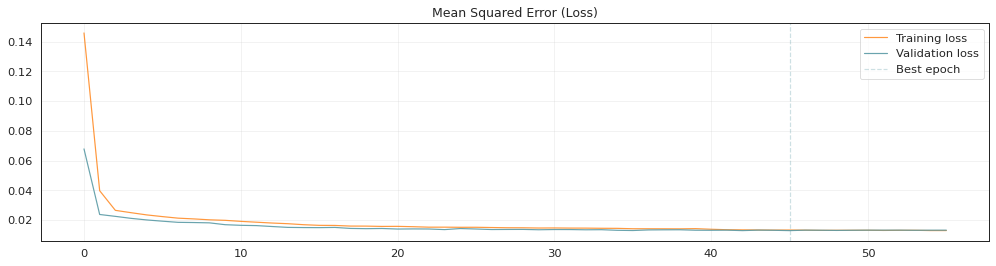

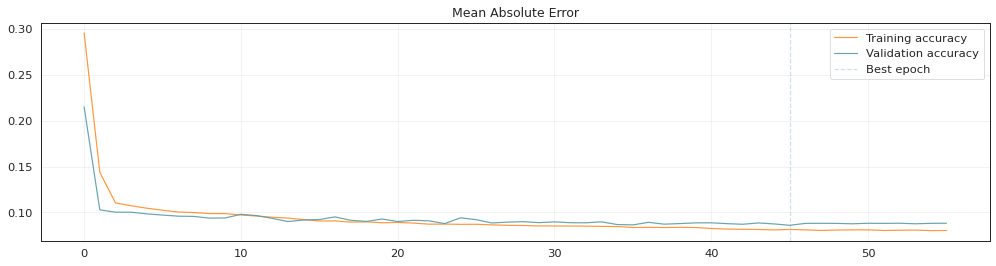

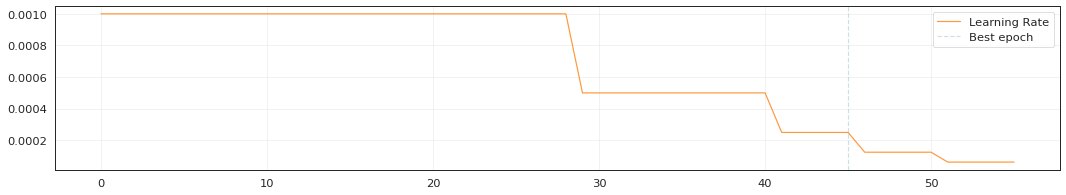

In [185]:
 best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [186]:
model.save('vanillawithtrasformation')
model = tfk.models.load_model('vanillawithtrasformation')


In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(474, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0125298975>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08560457>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

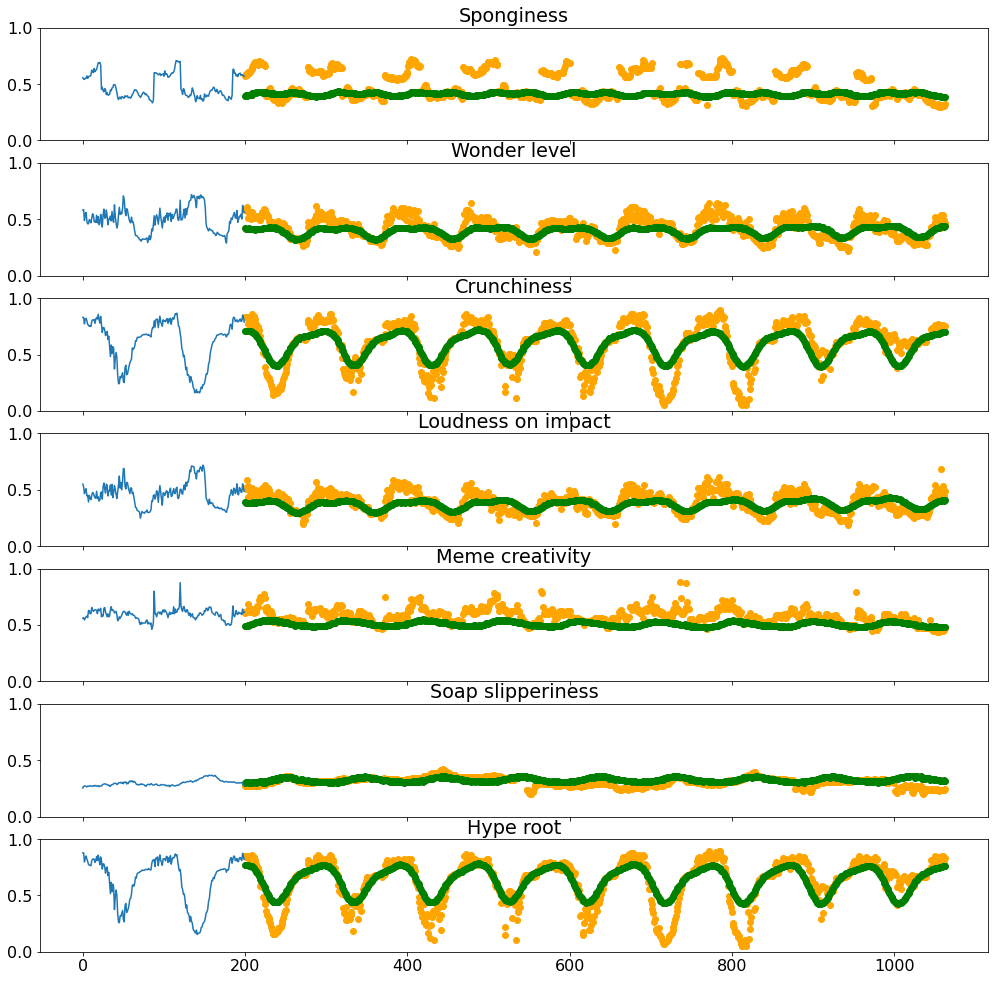

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

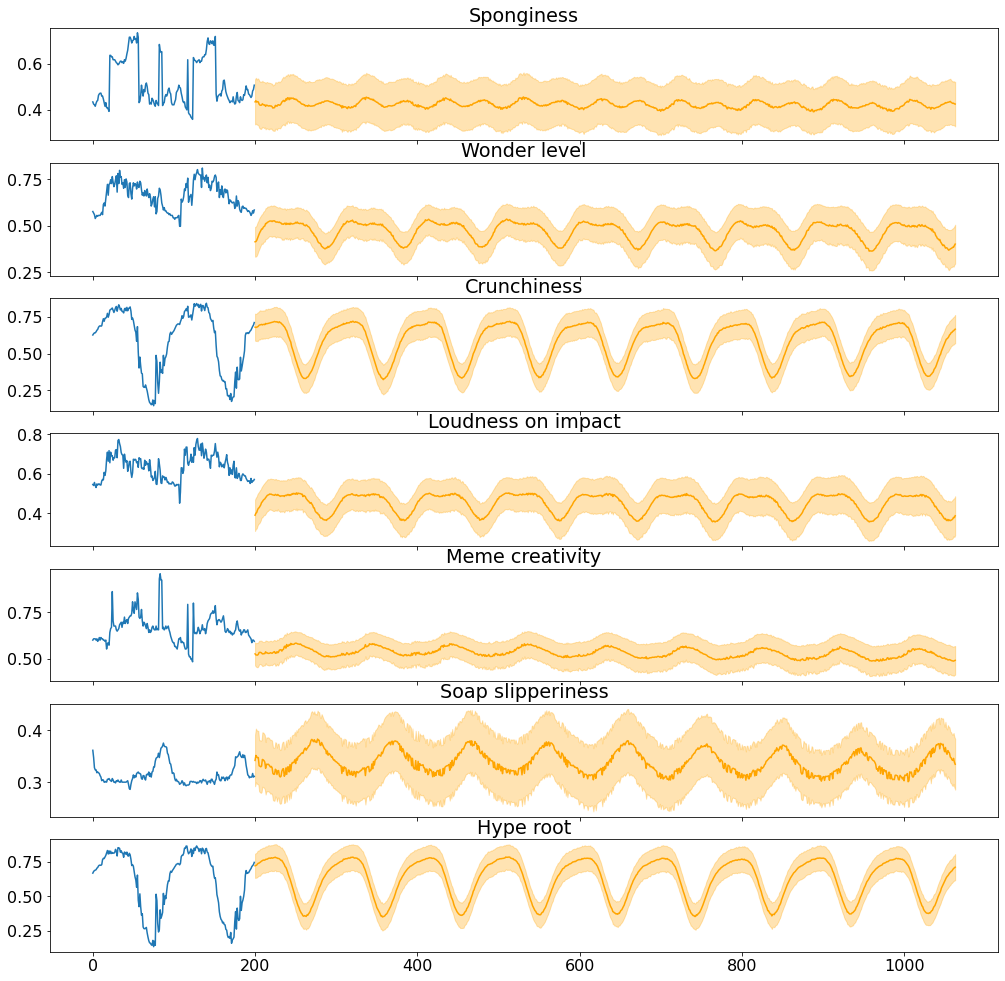

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

autoregressive

In [ ]:
target_labels = dataset.columns
telescope = 1

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6160, 200, 7), (6160, 1, 7), (680, 200, 7), (680, 1, 7))

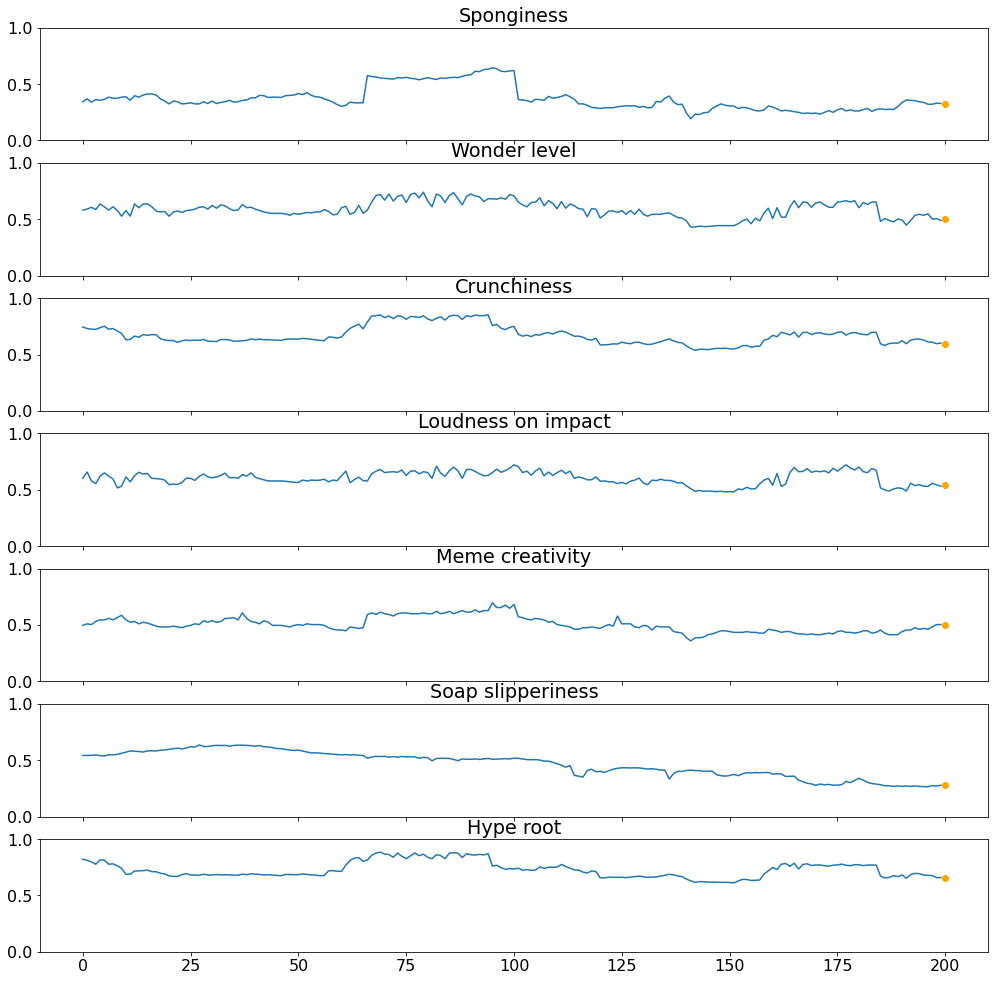

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 200, 128)         36864     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 200, 128)          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 200, 128)          49280     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 100, 128)         0         
 g1D)                                                            
                                                                 
 dense_11 (Dense)            (None, 100, 32)           4128  

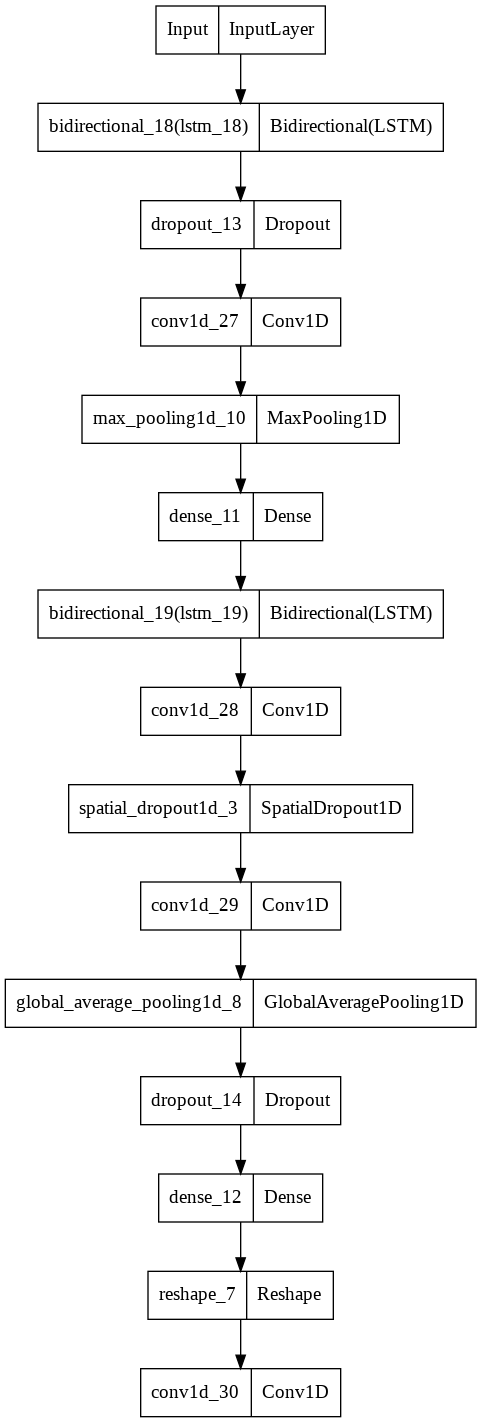

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

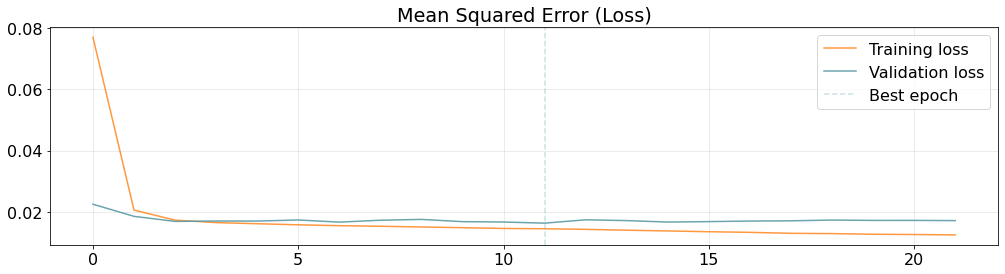

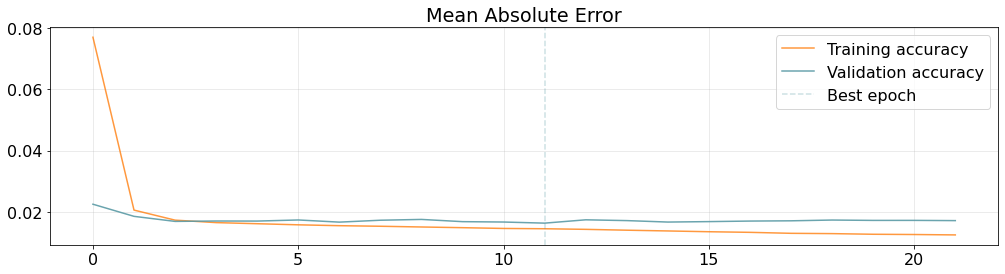

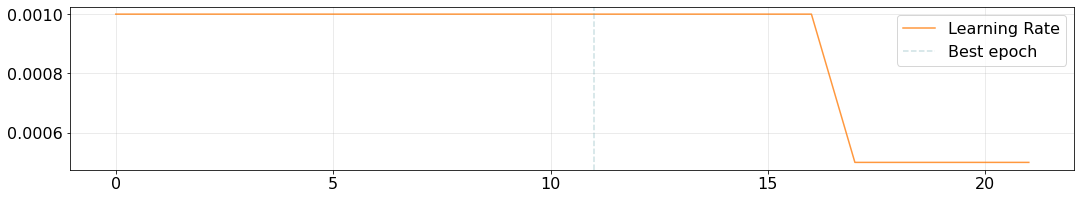

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mse'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-7)
    ]
).history

Epoch 1/200
87/87 [==============================] - 99s 1s/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.0756 - val_mse: 0.0756 - lr: 0.0010
Epoch 2/200
87/87 [==============================] - 99s 1s/step - loss: 0.0331 - mse: 0.0331 - val_loss: 0.0223 - val_mse: 0.0223 - lr: 0.0010
Epoch 3/200
87/87 [==============================] - 100s 1s/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0203 - val_mse: 0.0203 - lr: 0.0010
Epoch 4/200
87/87 [==============================] - 97s 1s/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0194 - val_mse: 0.0194 - lr: 0.0010
Epoch 5/200
87/87 [==============================] - 100s 1s/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0207 - val_mse: 0.0207 - lr: 0.0010
Epoch 6/200
87/87 [==============================] - 105s 1s/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0191 - val_mse: 0.0191 - lr: 0.0010
Epoch 7/200
87/87 [==============================] - 98s 1s/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0188 - val_mse: 0.0188 - 

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('AuroregressiveForecasting6')

In [ ]:

model = tfk.models.load_model('AuroregressiveForecasting6')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()